In [1]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score

from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, SAGEConv, NNConv
import matplotlib.pyplot as plt

In [2]:
%run dataset_nc.ipynb

Processing...
Done!


DATASET LOADED
Data(x=[40, 1], edge_index=[2, 41], edge_attr=[41, 1], y=[40, 36])


In [5]:
torch.manual_seed(42)
dataset = dataset_nc.shuffle()

train_dataset = dataset[:int(len(dataset) * 0.75)]
test_dataset = dataset[int(len(dataset) * 0.75):]

print(f'Number of graphs total: {len(dataset)}')
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(dataset[0])

Number of graphs total: 111
Number of training graphs: 83
Number of test graphs: 28
Data(x=[59, 1], edge_index=[2, 64], edge_attr=[64, 1], y=[59, 36])


In [6]:
from torch_geometric.loader import DataLoader

NUM_GRAPHS_PER_BATCH = 8
NUM_HIDDEN_CHANNELS = 64

train_loader = DataLoader(train_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [7]:
class GATGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
acc_values = []
for epoch in range(1, 501):
    loss = train()
    #val_f1 = test(val_loader)
    test_f1 = test(test_loader)
    loss_values.append(loss)
    acc_values.append(test_f1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Test: {test_f1:.4f}')


GATGNN(
  (conv1): GATConv(1, 64, heads=4)
  (lin1): Linear(in_features=1, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 36, heads=6)
  (lin3): Linear(in_features=256, out_features=36, bias=True)
)
Number of parameters:  200104
Epoch: 001, Loss: 0.5532, Test: 0.2613
Epoch: 002, Loss: 0.3456, Test: 0.4568
Epoch: 003, Loss: 0.2396, Test: 0.5223
Epoch: 004, Loss: 0.1210, Test: 0.5784
Epoch: 005, Loss: 0.0868, Test: 0.5336
Epoch: 006, Loss: 0.0785, Test: 0.6119
Epoch: 007, Loss: 0.0645, Test: 0.5179
Epoch: 008, Loss: 0.0598, Test: 0.6354
Epoch: 009, Loss: 0.0563, Test: 0.5551
Epoch: 010, Loss: 0.0579, Test: 0.6458
Epoch: 011, Loss: 0.0635, Test: 0.6155
Epoch: 012, Loss: 0.0576, Test: 0.6416
Epoch: 013, Loss: 0.0515, Test: 0.7047
Epoch: 014, Loss: 0.0521, Test: 0.7012
Epoch: 015, Loss: 0.0509, Test: 0.5597
Epoch: 016, Loss: 0.0509, Test: 0.7079
Epoch: 017, Loss: 0.0426, Test: 0.7031
Ep

Epoch: 203, Loss: 0.0134, Test: 0.8843
Epoch: 204, Loss: 0.0154, Test: 0.9241
Epoch: 205, Loss: 0.0291, Test: 0.8524
Epoch: 206, Loss: 0.0347, Test: 0.7982
Epoch: 207, Loss: 0.0250, Test: 0.8656
Epoch: 208, Loss: 0.0215, Test: 0.7747
Epoch: 209, Loss: 0.0253, Test: 0.8697
Epoch: 210, Loss: 0.0211, Test: 0.8299
Epoch: 211, Loss: 0.0190, Test: 0.9034
Epoch: 212, Loss: 0.0157, Test: 0.8775
Epoch: 213, Loss: 0.0159, Test: 0.8310
Epoch: 214, Loss: 0.0165, Test: 0.8384
Epoch: 215, Loss: 0.0167, Test: 0.8595
Epoch: 216, Loss: 0.0144, Test: 0.8632
Epoch: 217, Loss: 0.0132, Test: 0.9087
Epoch: 218, Loss: 0.0129, Test: 0.8500
Epoch: 219, Loss: 0.0134, Test: 0.9223
Epoch: 220, Loss: 0.0126, Test: 0.9092
Epoch: 221, Loss: 0.0117, Test: 0.8860
Epoch: 222, Loss: 0.0127, Test: 0.8615
Epoch: 223, Loss: 0.0167, Test: 0.8548
Epoch: 224, Loss: 0.0149, Test: 0.8662
Epoch: 225, Loss: 0.0125, Test: 0.8989
Epoch: 226, Loss: 0.0159, Test: 0.8678
Epoch: 227, Loss: 0.0410, Test: 0.8479
Epoch: 228, Loss: 0.0359,

Epoch: 414, Loss: 0.0086, Test: 0.9013
Epoch: 415, Loss: 0.0184, Test: 0.8842
Epoch: 416, Loss: 0.0163, Test: 0.8563
Epoch: 417, Loss: 0.0330, Test: 0.8287
Epoch: 418, Loss: 0.0198, Test: 0.8755
Epoch: 419, Loss: 0.0215, Test: 0.8767
Epoch: 420, Loss: 0.0289, Test: 0.7065
Epoch: 421, Loss: 0.0278, Test: 0.8542
Epoch: 422, Loss: 0.0208, Test: 0.8316
Epoch: 423, Loss: 0.0146, Test: 0.9153
Epoch: 424, Loss: 0.0124, Test: 0.9057
Epoch: 425, Loss: 0.0106, Test: 0.9058
Epoch: 426, Loss: 0.0101, Test: 0.9293
Epoch: 427, Loss: 0.0110, Test: 0.9126
Epoch: 428, Loss: 0.0094, Test: 0.9176
Epoch: 429, Loss: 0.0097, Test: 0.9134
Epoch: 430, Loss: 0.0118, Test: 0.9070
Epoch: 431, Loss: 0.0119, Test: 0.8789
Epoch: 432, Loss: 0.0186, Test: 0.8892
Epoch: 433, Loss: 0.0185, Test: 0.8686
Epoch: 434, Loss: 0.0803, Test: 0.7713
Epoch: 435, Loss: 0.0526, Test: 0.8244
Epoch: 436, Loss: 0.0340, Test: 0.8513
Epoch: 437, Loss: 0.0255, Test: 0.8452
Epoch: 438, Loss: 0.0189, Test: 0.8991
Epoch: 439, Loss: 0.0182,

GATGNN2(
  (conv1): GATConv(1, 64, heads=4)
  (lin1): Linear(in_features=1, out_features=256, bias=True)
  (conv2): GATConv(256, 64, heads=4)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (conv3): GATConv(256, 36, heads=6)
  (lin3): Linear(in_features=256, out_features=36, bias=True)
)
Number of parameters:  200104
Epoch: 001, Loss: 0.7513, Train: 0.1616, Test: 0.2242
Epoch: 002, Loss: 0.3280, Train: 0.3668, Test: 0.4672
Epoch: 003, Loss: 0.2441, Train: 0.4233, Test: 0.4454
Epoch: 004, Loss: 0.1371, Train: 0.4481, Test: 0.6012
Epoch: 005, Loss: 0.1082, Train: 0.4823, Test: 0.5517
Epoch: 006, Loss: 0.0812, Train: 0.5438, Test: 0.5779
Epoch: 007, Loss: 0.0701, Train: 0.5002, Test: 0.5648
Epoch: 008, Loss: 0.0670, Train: 0.5413, Test: 0.5808
Epoch: 009, Loss: 0.0638, Train: 0.6020, Test: 0.6114
Epoch: 010, Loss: 0.0587, Train: 0.5614, Test: 0.5881
Epoch: 011, Loss: 0.0616, Train: 0.5814, Test: 0.6215
Epoch: 012, Loss: 0.0584, Train: 0.5682, Test: 0.5648
Epoch: 013, Loss

Epoch: 147, Loss: 0.0216, Train: 0.8970, Test: 0.8588
Epoch: 148, Loss: 0.0245, Train: 0.8658, Test: 0.8224
Epoch: 149, Loss: 0.0238, Train: 0.8978, Test: 0.8617
Epoch: 150, Loss: 0.0187, Train: 0.9363, Test: 0.9301


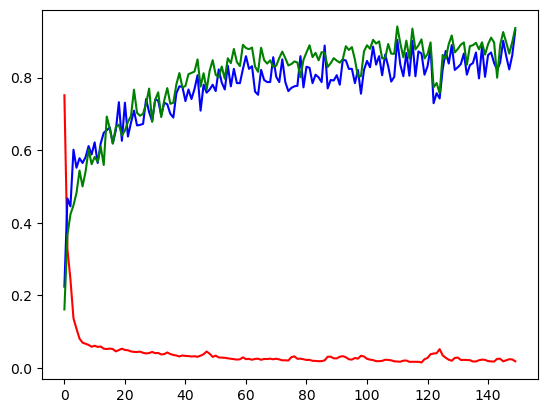

Max Accuracy: 0.9301


In [8]:
max_acc = 0
class GATGNN2(torch.nn.Module): # uses edge_attr
    def __init__(self):
        super().__init__()
        self.conv1 = GATConv(train_dataset.num_features, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv2 = GATConv(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS, heads=4, edge_dim=1)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        
        self.conv3 = GATConv(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes, heads=6, concat=False, edge_dim=1)
        self.lin3 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, train_dataset.num_classes)

        
    def forward(self, x, edge_index, edge_attr):
        x = F.elu(self.conv1(x, edge_index, edge_attr) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index, edge_attr) + self.lin2(x))
        x = self.conv3(x, edge_index, edge_attr) + self.lin3(x)
        return x



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATGNN2().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index, data.edge_attr), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def flatten(l):
    return [item for sublist in l for item in sublist]


@torch.no_grad()
def test2(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append([int(y.argmax()) for y in data.y])
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append([int(pred.argmax()) for pred in out])

    preds = flatten(preds)
    ys = flatten(ys)
    correct = 0
    
    for y, pred in zip(ys, preds):
        if(y == pred):
            correct += 1
    
    return correct / len(ys)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
train_acc_values = []
acc_values = []
for epoch in range(1, 501):
    loss = train()
    train_acc = test2(train_loader)
    test_acc = test2(test_loader)
    if(test_acc > max_acc):
        max_acc = test_acc
    
    loss_values.append(loss)
    acc_values.append(test_acc)
    train_acc_values.append(train_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Train: {train_acc:.4f}, 'f'Test: {test_acc:.4f}')
    
    if(test_acc >= 0.92):
        break

plt.plot(loss_values, 'r', acc_values, 'b', train_acc_values, 'g')
plt.show()
print(f'Max Accuracy: {max_acc:.4f}')

In [116]:
torch.save(model, 'models/model_nc.pth')

In [119]:
loaded_model = torch.load('models/model_nc.pth')
loaded_model.eval()
test_acc = test2(test_loader)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9248


In [93]:
def flatten(l):
    return [item for sublist in l for item in sublist]

@torch.no_grad()
def test2(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append([int(y.argmax()) for y in data.y])
        out = model(data.x.to(device), data.edge_index.to(device), edge_attr=data.edge_attr.to(device))
        preds.append([int(pred.argmax()) for pred in out])

    preds = flatten(preds)
    ys = flatten(ys)
    print(len(preds))
    print(len(ys))
    correct = 0
    
    for y, pred in zip(ys, preds):
        if(y == pred):
            correct += 1
    
    print(correct / len(ys))
    

test_f1 = test2(test_loader)

700
700
0.8228571428571428


SAGEGNN(
  (conv1): SAGEConv(1, 64)
  (conv2): SAGEConv(64, 256)
  (conv3): SAGEConv(256, 512)
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=35, bias=True)
)
Number of parameters:  445923
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 001, Loss: 0.4150, Test: 0.0000
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 002, Loss: 0.1913, Test: 0.0028
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 003, Loss: 0.1659, Test: 0.1474
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 004, Loss: 0.1468, Test: 0.0056
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 005, Loss: 0.1467, Test: 0.0000
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 006, Loss: 0.1410, Test: 0.0887
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([2

torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 080, Loss: 0.0448, Test: 0.5943
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 081, Loss: 0.0441, Test: 0.5073
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 082, Loss: 0.0433, Test: 0.5548
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 083, Loss: 0.0422, Test: 0.5163
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 084, Loss: 0.0406, Test: 0.5822
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 085, Loss: 0.0406, Test: 0.6576
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 086, Loss: 0.0390, Test: 0.6053
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 087, Loss: 0.0393, Test: 0.6157
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 088, Loss: 0.0386, Test: 0.5895
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size(

torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 161, Loss: 0.0269, Test: 0.7011
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 162, Loss: 0.0258, Test: 0.7539
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 163, Loss: 0.0255, Test: 0.7427
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 164, Loss: 0.0247, Test: 0.7648
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 165, Loss: 0.0255, Test: 0.7096
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 166, Loss: 0.0247, Test: 0.7500
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 167, Loss: 0.0258, Test: 0.7600
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 168, Loss: 0.0254, Test: 0.7270
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size([215, 35])
Epoch: 169, Loss: 0.0254, Test: 0.7701
torch.Size([274, 35])
torch.Size([211, 35])
torch.Size(

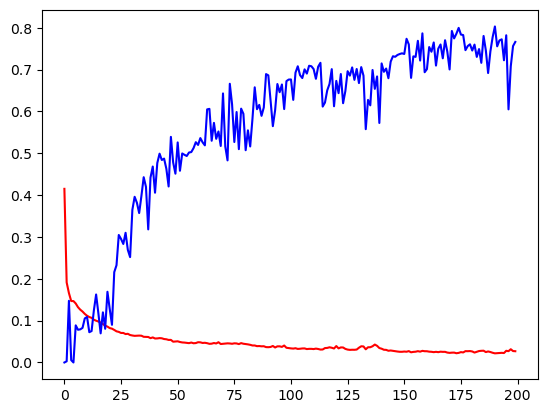

In [221]:
class SAGEGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(42)
        self.conv1 = SAGEConv(train_dataset.num_node_features, NUM_HIDDEN_CHANNELS)
        self.conv2 = SAGEConv(NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        self.conv3 = SAGEConv(4 * NUM_HIDDEN_CHANNELS, 8 * NUM_HIDDEN_CHANNELS)
        self.lin1 = torch.nn.Linear(8 * NUM_HIDDEN_CHANNELS, 4 * NUM_HIDDEN_CHANNELS)
        self.lin2 = torch.nn.Linear(4 * NUM_HIDDEN_CHANNELS, NUM_HIDDEN_CHANNELS)
        self.lin3 = torch.nn.Linear(NUM_HIDDEN_CHANNELS, train_dataset.num_classes)
        

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
#         x = self.conv3(x, edge_index)
#         x = x.relu()
#         x = self.lin1(x)
#         x = x.relu()
        x = self.lin2(x)
        x = x.relu()
        x = self.lin3(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SAGEGNN().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
# loss_op = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * data.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.x.to(device), data.edge_index.to(device))
        print(out.shape)
        preds.append((out > 0).float().cpu())

    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0

loss_values = []
acc_values = []
for epoch in range(1, 201):
    loss = train()
    test_f1 = test(test_loader)
    loss_values.append(loss)
    acc_values.append(test_f1)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, 'f'Test: {test_f1:.4f}')

plt.plot(loss_values, 'r', acc_values, 'b',)
plt.show()